In [1]:
CONTEXT_LENGTH = None
POZITIV_PERCENTAGE_TO_KEEP = 100
NEGATIV_PERCENTAGE_TO_KEEP = 100
SEMLEGES_PERCENTAGE_TO_KEEP = 25

USE_STOPWORDS = False
LOAD_CHECKPOINT = False
CHECKPOINT_SUBDIR = 'balanced_bert/'
CHECKPOINT_PREFIX = 'restore_best_weight_25_semleges/'
ITER = "1"

In [2]:
# Imports

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
import json

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
from sklearn.preprocessing import LabelEncoder 

from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping

import tensorflow as tf

import seaborn as sn

from nltk.corpus import stopwords

import pickle

# BERT model, tokenizer
from tensorflow.python.keras.layers import Flatten

from transformers import TFBertForSequenceClassification, TFAutoModel , AutoTokenizer

In [3]:
# Constants

# Specialis karakterekkel a maximalis kodolt szoveg max hossza
SEED = 42

SHUFFLE_RANDOM_STATE = SEED
TRAIN_RANDOM_STATE = SEED
TEST_RANDOM_STATE = SEED
RANDOM_SEED = SEED
NP_SEED = SEED
TF_SEED = SEED
PYTHON_HASH_SEED = SEED

TEXT = 'Sentence'
START_TOKEN = 'START'
TOKEN_LEN = 'LEN'
Y_HEADER = 'LABEL'
LABELS = {
    "NEG": 0,
    "SEM": 1,
    "POZ": 2
}

MAX_SEQUENCE_LENGTH = 64

BATCH_SIZE = 16
EPOCHS = 30

# Maximum hány dokumentumot nézzünk. None esetén mindet
TRAIN_PROCESSED_MAX_DOCUMENTS = None
# Maximum hány dokumentumot nézzünk. None esetén mindet
TEST_PROCESSED_MAX_DOCUMENTS = None

In [4]:
os.environ['PYTHONHASHSEED']=str(PYTHON_HASH_SEED)
np.random.seed(NP_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(TF_SEED)
tf.compat.v1.set_random_seed(TF_SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS'] = '1'
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

path = 'checkpoints/' + CHECKPOINT_SUBDIR + CHECKPOINT_PREFIX

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Text processing

def extend_context(text, context, left_index, right_index, context_length):
    if context_length is None:
        context_length = len(text)
    if type(text) != list:
        text = text.split()
    start_size = 0
    while start_size < context_length:
        if left_index > 0:
            left_index -= 1
            context.insert(0, text[left_index])
            if len(text[left_index]) > 1:
                start_size += 1
        if right_index < len(text) -1:
            right_index += 1
            context.append(text[right_index])
            if len(text[right_index]) > 1:
                start_size += 1
        if left_index <= 0 and right_index >= len(text) -1:
            break
    return ' '.join(context)

#Ha a context_length None, akkor a teljes szövegre fut.
def contextualize(index, debug = False, context_length=None):
    global fix
    text = ' '.join([i for i in re.split(r'( - |(?![%.-])\W)|(-e[\n ])', dataset[TEXT].iloc[index]) if i])
    context_start_index = int(dataset[START_TOKEN].iloc[index] - 1)
    context_stop_index = int(context_start_index+dataset[TOKEN_LEN].iloc[index] - 1)

    context_name_tokens = \
        [t for t in text.split()[context_start_index:context_stop_index+1]]

    context_list = context_name_tokens
    left_index = context_start_index
    right_index = context_stop_index
    context = extend_context(text, context_list, left_index, right_index, context_length)
    return context

def delete_labeled_rows(dataset, label, percentage_to_remain = 10):
    neutral_ids = dataset.index[dataset[Y_HEADER] == label].tolist()
    neutral_id_drop = set(random.sample(range(len(neutral_ids)), int(len(neutral_ids) * percentage_to_remain / 100)))
    ids_to_delete = [x for i,x in enumerate(neutral_ids) if not i in neutral_id_drop]
    return dataset.drop(ids_to_delete)

In [7]:
# Load and set up data

dataset = pd.read_csv('db/train.csv', sep=';')
dataset[Y_HEADER] = dataset[Y_HEADER].map(LABELS)
dataset = shuffle(dataset, random_state=SHUFFLE_RANDOM_STATE)
dataset.info()

dataset = delete_labeled_rows(dataset, LABELS['SEM'], percentage_to_remain=SEMLEGES_PERCENTAGE_TO_KEEP)
dataset = delete_labeled_rows(dataset, LABELS['NEG'], percentage_to_remain=NEGATIV_PERCENTAGE_TO_KEEP)
dataset = delete_labeled_rows(dataset, LABELS['POZ'], percentage_to_remain=POZITIV_PERCENTAGE_TO_KEEP)

X_list = []
print(len(dataset.index))
for i  in range(len(dataset.index)):
    X_list.append(contextualize(i, context_length=CONTEXT_LENGTH))

print(X_list[:10])
X = np.asarray(X_list)
y = dataset[Y_HEADER].values


X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=TRAIN_RANDOM_STATE)

X_dev, X_test, y_dev, y_test = train_test_split(X_rem, y_rem, train_size=0.5, random_state=TEST_RANDOM_STATE)


y_train_labels = y_train
y_dev_labels = y_dev
y_test_labels = y_test
y_train = to_categorical(y_train, 3)
y_dev = to_categorical(y_dev, 3)
y_test = to_categorical(y_test, 3)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7700 entries, 3856 to 7270
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        7700 non-null   int64 
 1   START     7700 non-null   int64 
 2   LEN       7700 non-null   int64 
 3   Entity    7700 non-null   object
 4   Sentence  7700 non-null   object
 5   URL       7700 non-null   object
 6   LABEL     7700 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 481.2+ KB
3422
['Demján utalt arra : már a korábbi években is hangoztatta , hogy reformok végrehajtása nélkül Magyarország tíz évig Európa legszegényebb országa lesz.', 'A kitüntetést annak idején Bajcsy-Zsilinszky lapjában , az Előörsben József Attila egy szignó nélküli cikkében hevesen támadta , nemes egyszer ? séggel " kultúrfityegőnek " nevezve azt.', 'Tudható volt , hogy Németh Szilárd pozícióhalmozása előbb-utóbb Csepel kárára történik majd.', '- Immár két éve , hogy megrendezzük a Zöld Állomás ü

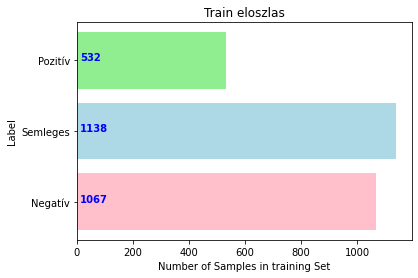

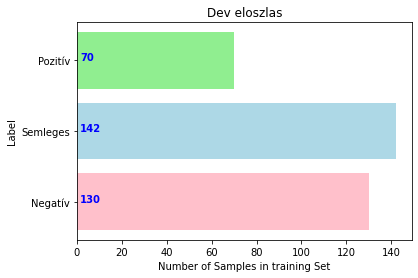

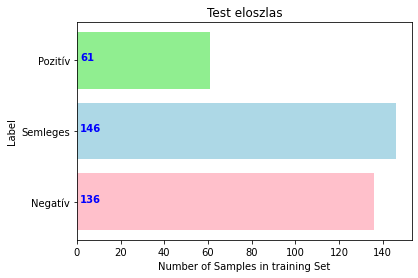

In [8]:
# eloszlas

def plot_label_counts(y, title='y labels'):
    unique, counts = np.unique(y, return_counts=True)
    b = dict(zip(unique, counts))
    plt.barh(range(len(b)), list(b.values()), align='center', color=['pink', 'lightblue', 'lightgreen'])
    y_values = ["Negatív", "Semleges", "Pozitív"]
    y_axis = np.arange(0, 3, 1)
    plt.yticks(y_axis, y_values)
    plt.title(title)
    plt.xlabel('Number of Samples in training Set')
    plt.ylabel('Label')
    ax = plt.gca()
    for i, v in enumerate(b.values()):
        plt.text(ax.get_xlim()[1]/100, i, str(v), color='blue', fontweight='bold')
    plt.show()

plot_label_counts(y_train_labels, 'Train eloszlas')
plot_label_counts(y_dev_labels, 'Dev eloszlas')
plot_label_counts(y_test_labels, 'Test eloszlas')


In [9]:
bert_tokenizer = AutoTokenizer.from_pretrained("SZTAKI-HLT/hubert-base-cc")
bert_model = TFBertForSequenceClassification.from_pretrained("SZTAKI-HLT/hubert-base-cc", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at SZTAKI-HLT/hubert-base-cc and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
all_stopwords = []

def apply_stopwords(sentences):
    global all_stopwords
    corpus = []
    for sen in sentences:
        sentence = sen.split()
        all_stopwords = stopwords.words('hungarian')
        whitelist = ["ne", "nem", "se", "sem"]
        sentence = [word for word in sentence if (word.lower() not in all_stopwords or word.lower() in whitelist)
                 and len(word) > 1]
        sentence = ' '.join(sentence)
        corpus.append(sentence)

    return corpus


In [11]:
def batch_encode(X):
    return bert_tokenizer.batch_encode_plus(
    X,
    truncation=True,
    max_length=MAX_SEQUENCE_LENGTH,
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    padding='max_length', # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)
X_train = X_train.tolist() if not USE_STOPWORDS else apply_stopwords(X_train.tolist())
X_dev = X_dev.tolist() if not USE_STOPWORDS else apply_stopwords(X_dev.tolist())
X_test = X_test.tolist() if not USE_STOPWORDS else apply_stopwords(X_test.tolist())


X_train = batch_encode(X_train[:TRAIN_PROCESSED_MAX_DOCUMENTS])
X_dev = batch_encode(X_dev[:TEST_PROCESSED_MAX_DOCUMENTS])
X_test = batch_encode(X_test[:TEST_PROCESSED_MAX_DOCUMENTS])
y_train = y_train[:TRAIN_PROCESSED_MAX_DOCUMENTS]
y_dev = y_dev[:TEST_PROCESSED_MAX_DOCUMENTS]
y_test = y_test[:TEST_PROCESSED_MAX_DOCUMENTS]

In [12]:
def create_model():
    input_ids = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input((64,), dtype=tf.int32, name='attention_mask')
    output = bert_model([input_ids, attention_mask])[0]
    output = tf.keras.layers.Dropout(rate=0.15)(output)
    output = tf.keras.layers.Dense(3, activation='softmax')(output)
    result = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return result

model = create_model()

opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
print(bert_model.config)
model.summary()


BertConfig {
  "_name_or_path": "SZTAKI-HLT/hubert-base-cc",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32001
}

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)   

In [14]:
checkpoint_path = path + 'cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
def calculate_weights():
    y_categorical = np.argmax(y_train, axis=-1)
    class_weights = list(class_weight.compute_class_weight('balanced', classes=np.unique(dataset[Y_HEADER]), y=y_categorical))
    weights={}
    
    for index, weight in enumerate(class_weights) :
      weights[index]=weight
    
    return weights

def get_history_as_text(history, epoch):
    return f'Epoch {epoch+1: <3}: loss: {format(history["loss"][epoch], ".4f")} - accuracy: {format(history["accuracy"][epoch], ".4f")} - val_loss: {format(history["val_loss"][epoch], ".4f")} - val_accuracy: {format(history["val_accuracy"][epoch], ".4f")}'

def fit_model():
    weights = calculate_weights()
    print(weights)
    if not LOAD_CHECKPOINT:
        if ITER == "9":
            history = model.fit(
                x=X_train.values(),
                class_weight=weights,
                y=y_train,
                validation_data=(X_dev.values(), y_dev),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True), cp_callback]
            )
        else:
            history = model.fit(
                x=X_train.values(),
                class_weight=weights,
                y=y_train,
                validation_data=(X_dev.values(), y_dev),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)]
            )
        with open(path + '.history', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        text_file = open(path + "history" + ITER + ".txt", "w")
        print(len(history.history['loss']))
        for i in range(len(history.history['loss'])):
            history_text = get_history_as_text(history.history, i)
            print(history_text)
            text_file.writelines(history_text + '\n')
        text_file.close()
    else:
        model.load_weights(checkpoint_path)
        history = pickle.load(open(path + '.history', "rb"))
        for i in range(len(history['loss'])):
            history_text = get_history_as_text(history, i)
            print(history_text)
    result = model.evaluate(X_test.values(), y_test)
    predict = model.predict(X_test.values())
    np_predict = np.argmax(predict,axis=1)
    return history, result, np_predict


In [ ]:
#history, result, predict = fit_model()

In [ ]:
le = LabelEncoder()

def evaluate(predict, result, y):
    y_le = le.fit_transform(y[:TEST_PROCESSED_MAX_DOCUMENTS])
    print('Classification report:')
    print(classification_report(y_le, predict))
    print(f'Accuracy: {accuracy_score(y_le, predict): >43}')
    print(f'Accuracy from evaluation: {result[1]: >27}')
    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(y_le, predict),
                         index=[i for i in ['negative', 'neutral', 'positive']],
                         columns=[i for i in ['negative', 'neutral', 'positive']])
    if not LOAD_CHECKPOINT:
        with open(path + "results" + ITER + ".txt", "w") as text_file:
            df_cm_string = df_cm.to_string(header=False, index=False)
            text_file.write('Classification report:\n')
            text_file.write(classification_report(y_le, predict))
            text_file.write(f'\nAccuracy: {accuracy_score(y_le, predict): >43}\n')
            text_file.write(f'Accuracy from evaluation: {result[1]: >27}\n')
            text_file.write('\nConfusion matrix:\n')
            text_file.write(df_cm_string)
    plt.figure(figsize=(10,7))
    plt.title(CHECKPOINT_PREFIX[:-1])
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    if not LOAD_CHECKPOINT:
        plt.savefig(path + 'accuracy-' + format(result[1], ".4f") + ITER + '.jpg')
    plt.show()
    
#evaluate(predict, result, y_test_labels)

In [ ]:
import winsound

for i in range(1,10):
  try: 
    ITER = str(i)
    print("Iteration ", ITER)
    history, result, predict = fit_model()
    evaluate(predict, result, y_test_labels)
  except Exception as e:
    for i in range(1, 5):
      winsound.Beep(100 + i * 100, 400)


for i in range(5, 12):
  winsound.Beep(100 + i * 100, 400)

In [16]:
import winsound

for i in range(1,10):
  try: 
    ITER = str(i)
    print("Iteration ", ITER)
    history, result, predict = fit_model()
    evaluate(predict, result, y_test_labels)
  except Exception as e:
    for i in range(1, 5):
      winsound.Beep(100 + i * 100, 400)


for i in range(5, 12):
  winsound.Beep(100 + i * 100, 400)

In [17]:
le = LabelEncoder()

def evaluate(predict, result, y):
    y_le = le.fit_transform(y[:TEST_PROCESSED_MAX_DOCUMENTS])
    print('Classification report:')
    print(classification_report(y_le, predict))
    print(f'Accuracy: {accuracy_score(y_le, predict): >43}')
    print(f'Accuracy from evaluation: {result[1]: >27}')
    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(y_le, predict),
                         index=[i for i in ['negative', 'neutral', 'positive']],
                         columns=[i for i in ['negative', 'neutral', 'positive']])
    if not LOAD_CHECKPOINT:
        with open(path + "results" + ITER + ".txt", "w") as text_file:
            df_cm_string = df_cm.to_string(header=False, index=False)
            text_file.write('Classification report:\n')
            text_file.write(classification_report(y_le, predict))
            text_file.write(f'\nAccuracy: {accuracy_score(y_le, predict): >43}\n')
            text_file.write(f'Accuracy from evaluation: {result[1]: >27}\n')
            text_file.write('\nConfusion matrix:\n')
            text_file.write(df_cm_string)
    plt.figure(figsize=(10,7))
    plt.title(CHECKPOINT_PREFIX[:-1])
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    if not LOAD_CHECKPOINT:
        plt.savefig(path + 'accuracy-' + format(result[1], ".4f") + ITER + '.jpg')
    plt.show()
    
#evaluate(predict, result, y_test_labels)

Iteration  1
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 134s 712ms/step - loss: 0.5928 - accuracy: 0.7567 - val_loss: 0.3658 - val_accuracy: 0.8713
Epoch 2/30
172/172 [==============================] - 148s 861ms/step - loss: 0.3286 - accuracy: 0.8856 - val_loss: 0.4036 - val_accuracy: 0.8684
Epoch 3/30
172/172 [==============================] - 155s 901ms/step - loss: 0.2467 - accuracy: 0.9127 - val_loss: 0.3665 - val_accuracy: 0.8830
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
3
Epoch 1  : loss: 0.5928 - accuracy: 0.7567 - val_loss: 0.3658 - val_accuracy: 0.8713
Epoch 2  : loss: 0.3286 - accuracy: 0.8856 - val_loss: 0.4036 - val_accuracy: 0.8684
Epoch 3  : loss: 0.2467 - accuracy: 0.9127 - val_loss: 0.3665 - val_accuracy: 0.8830
11/11 [==============================] - 7s 602ms/step - loss: 0.3877 - accuracy: 0.8571
Classification report:
              precision   

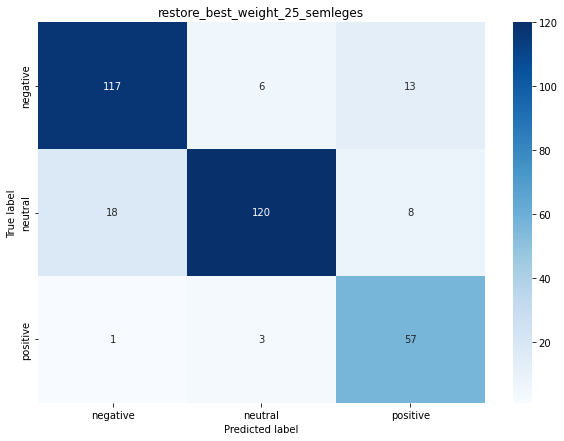

Iteration  2
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 155s 904ms/step - loss: 0.3315 - accuracy: 0.8758 - val_loss: 0.3432 - val_accuracy: 0.8743
Epoch 2/30
172/172 [==============================] - 159s 928ms/step - loss: 0.2453 - accuracy: 0.9116 - val_loss: 0.3604 - val_accuracy: 0.8889
Epoch 3/30
172/172 [==============================] - 158s 920ms/step - loss: 0.2270 - accuracy: 0.9167 - val_loss: 0.3857 - val_accuracy: 0.8743
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
3
Epoch 1  : loss: 0.3315 - accuracy: 0.8758 - val_loss: 0.3432 - val_accuracy: 0.8743
Epoch 2  : loss: 0.2453 - accuracy: 0.9116 - val_loss: 0.3604 - val_accuracy: 0.8889
Epoch 3  : loss: 0.2270 - accuracy: 0.9167 - val_loss: 0.3857 - val_accuracy: 0.8743
11/11 [==============================] - 6s 577ms/step - loss: 0.3687 - accuracy: 0.8950
Classification report:
              precision   

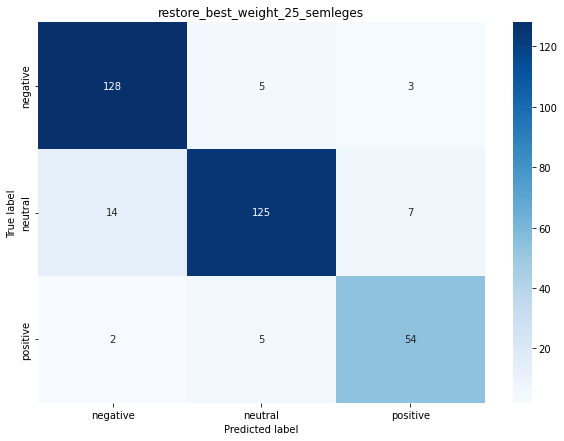

Iteration  3
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 157s 915ms/step - loss: 0.2555 - accuracy: 0.9087 - val_loss: 0.2827 - val_accuracy: 0.8801
Epoch 2/30
172/172 [==============================] - 161s 936ms/step - loss: 0.2219 - accuracy: 0.9218 - val_loss: 0.4057 - val_accuracy: 0.8713
Epoch 3/30
172/172 [==============================] - 156s 907ms/step - loss: 0.1825 - accuracy: 0.9342 - val_loss: 0.5057 - val_accuracy: 0.8596
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
3
Epoch 1  : loss: 0.2555 - accuracy: 0.9087 - val_loss: 0.2827 - val_accuracy: 0.8801
Epoch 2  : loss: 0.2219 - accuracy: 0.9218 - val_loss: 0.4057 - val_accuracy: 0.8713
Epoch 3  : loss: 0.1825 - accuracy: 0.9342 - val_loss: 0.5057 - val_accuracy: 0.8596
11/11 [==============================] - 6s 571ms/step - loss: 0.3861 - accuracy: 0.8630
Classification report:
              precision   

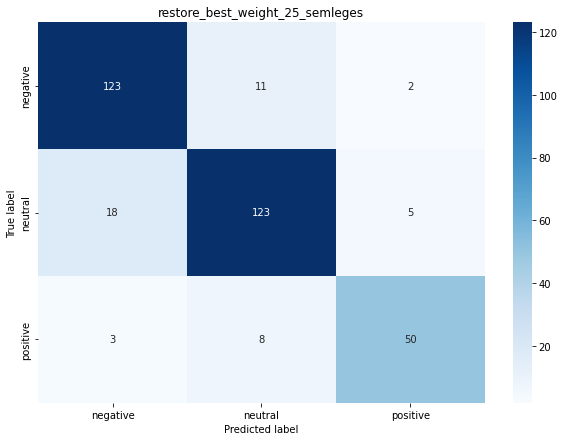

Iteration  4
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 159s 926ms/step - loss: 0.1910 - accuracy: 0.9331 - val_loss: 0.3674 - val_accuracy: 0.8772
Epoch 2/30
172/172 [==============================] - 155s 904ms/step - loss: 0.1708 - accuracy: 0.9342 - val_loss: 0.3626 - val_accuracy: 0.8567
Epoch 3/30
172/172 [==============================] - 157s 911ms/step - loss: 0.1536 - accuracy: 0.9364 - val_loss: 0.4153 - val_accuracy: 0.8772
Epoch 4/30
172/172 [==============================] - 154s 896ms/step - loss: 0.1376 - accuracy: 0.9445 - val_loss: 0.4376 - val_accuracy: 0.8626
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
4
Epoch 1  : loss: 0.1910 - accuracy: 0.9331 - val_loss: 0.3674 - val_accuracy: 0.8772
Epoch 2  : loss: 0.1708 - accuracy: 0.9342 - val_loss: 0.3626 - val_accuracy: 0.8567
Epoch 3  : loss: 0.1536 - accuracy: 0.9364 - val_loss: 0.4153 - val_accuracy:

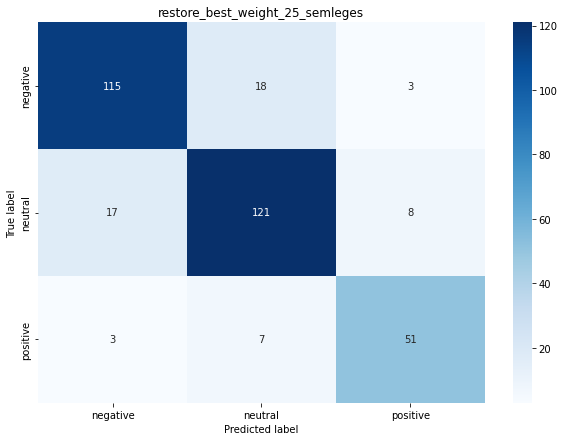

Iteration  5
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 153s 891ms/step - loss: 0.1505 - accuracy: 0.9404 - val_loss: 0.3516 - val_accuracy: 0.8772
Epoch 2/30
172/172 [==============================] - 157s 911ms/step - loss: 0.1339 - accuracy: 0.9503 - val_loss: 0.4350 - val_accuracy: 0.8772
Epoch 3/30
172/172 [==============================] - 155s 899ms/step - loss: 0.1182 - accuracy: 0.9488 - val_loss: 0.4626 - val_accuracy: 0.8801
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
3
Epoch 1  : loss: 0.1505 - accuracy: 0.9404 - val_loss: 0.3516 - val_accuracy: 0.8772
Epoch 2  : loss: 0.1339 - accuracy: 0.9503 - val_loss: 0.4350 - val_accuracy: 0.8772
Epoch 3  : loss: 0.1182 - accuracy: 0.9488 - val_loss: 0.4626 - val_accuracy: 0.8801
11/11 [==============================] - 7s 611ms/step - loss: 0.4910 - accuracy: 0.8630
Classification report:
              precision   

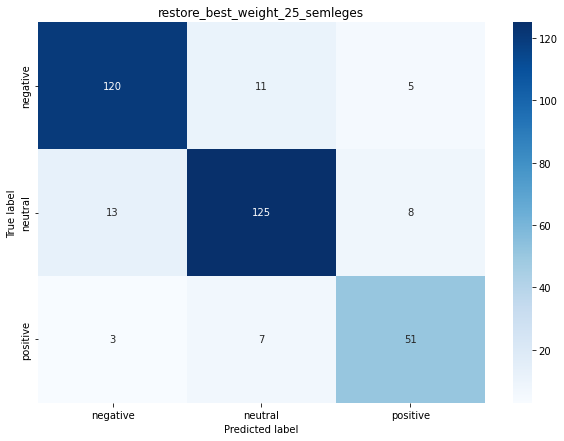

Iteration  6
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 3071s 18s/step - loss: 0.1507 - accuracy: 0.9470 - val_loss: 0.5010 - val_accuracy: 0.8655
Epoch 2/30
172/172 [==============================] - 99s 577ms/step - loss: 0.1815 - accuracy: 0.9324 - val_loss: 0.3519 - val_accuracy: 0.8743
Epoch 3/30
172/172 [==============================] - 105s 612ms/step - loss: 0.1384 - accuracy: 0.9445 - val_loss: 0.5630 - val_accuracy: 0.8567
Epoch 4/30
172/172 [==============================] - 114s 661ms/step - loss: 0.1081 - accuracy: 0.9565 - val_loss: 0.5878 - val_accuracy: 0.8772
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
4
Epoch 1  : loss: 0.1507 - accuracy: 0.9470 - val_loss: 0.5010 - val_accuracy: 0.8655
Epoch 2  : loss: 0.1815 - accuracy: 0.9324 - val_loss: 0.3519 - val_accuracy: 0.8743
Epoch 3  : loss: 0.1384 - accuracy: 0.9445 - val_loss: 0.5630 - val_accuracy: 0

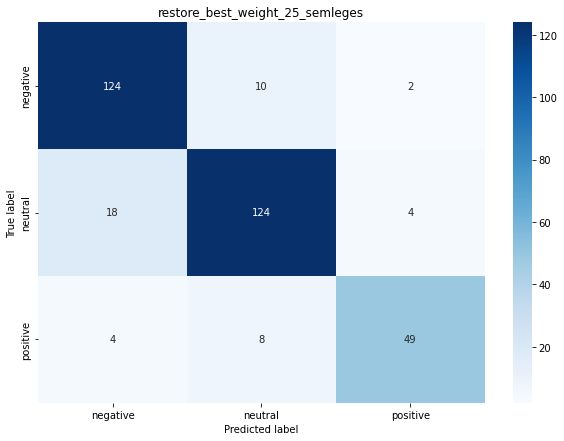

Iteration  7
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 120s 699ms/step - loss: 0.1232 - accuracy: 0.9510 - val_loss: 0.4941 - val_accuracy: 0.8480
Epoch 2/30
172/172 [==============================] - 126s 733ms/step - loss: 0.1098 - accuracy: 0.9529 - val_loss: 0.4534 - val_accuracy: 0.8801
Epoch 3/30
172/172 [==============================] - 128s 745ms/step - loss: 0.1213 - accuracy: 0.9478 - val_loss: 0.5238 - val_accuracy: 0.8567
Epoch 4/30
172/172 [==============================] - 131s 764ms/step - loss: 0.1074 - accuracy: 0.9558 - val_loss: 0.5729 - val_accuracy: 0.8626
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
4
Epoch 1  : loss: 0.1232 - accuracy: 0.9510 - val_loss: 0.4941 - val_accuracy: 0.8480
Epoch 2  : loss: 0.1098 - accuracy: 0.9529 - val_loss: 0.4534 - val_accuracy: 0.8801
Epoch 3  : loss: 0.1213 - accuracy: 0.9478 - val_loss: 0.5238 - val_accuracy:

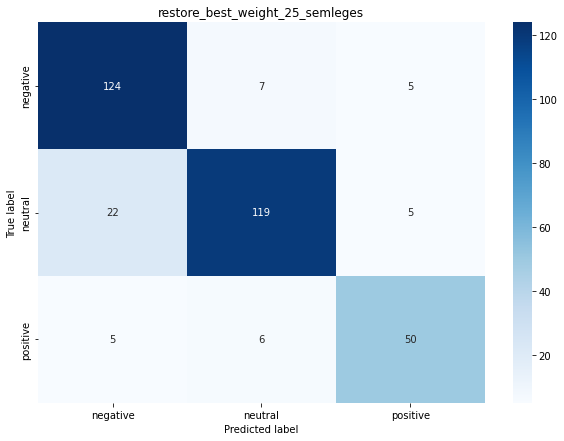

Iteration  8
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 132s 770ms/step - loss: 0.1080 - accuracy: 0.9554 - val_loss: 0.6699 - val_accuracy: 0.8129
Epoch 2/30
172/172 [==============================] - 136s 790ms/step - loss: 0.1236 - accuracy: 0.9412 - val_loss: 0.5445 - val_accuracy: 0.8772
Epoch 3/30
172/172 [==============================] - 137s 800ms/step - loss: 0.1151 - accuracy: 0.9514 - val_loss: 0.5844 - val_accuracy: 0.8655
Epoch 4/30
172/172 [==============================] - 141s 818ms/step - loss: 0.1385 - accuracy: 0.9445 - val_loss: 0.6704 - val_accuracy: 0.8480
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
4
Epoch 1  : loss: 0.1080 - accuracy: 0.9554 - val_loss: 0.6699 - val_accuracy: 0.8129
Epoch 2  : loss: 0.1236 - accuracy: 0.9412 - val_loss: 0.5445 - val_accuracy: 0.8772
Epoch 3  : loss: 0.1151 - accuracy: 0.9514 - val_loss: 0.5844 - val_accuracy:

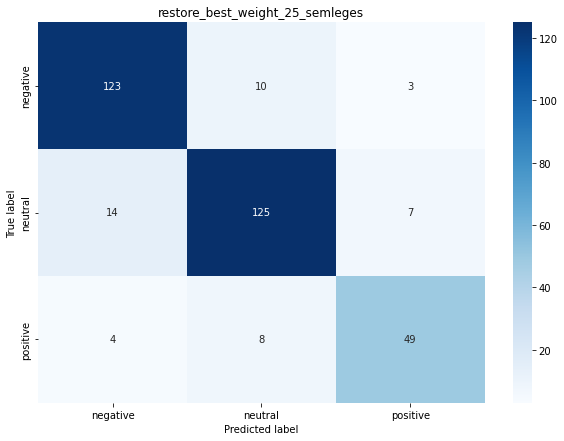

Iteration  9
{0: 0.8550452983442675, 1: 0.8016988869361453, 2: 1.7149122807017543}
Epoch 1/30
172/172 [==============================] - 141s 823ms/step - loss: 0.1087 - accuracy: 0.9518 - val_loss: 0.7730 - val_accuracy: 0.8480

Epoch 00001: saving model to checkpoints/balanced_bert/restore_best_weight_25_semleges\cp.ckpt
Epoch 2/30
172/172 [==============================] - 133s 772ms/step - loss: 0.1216 - accuracy: 0.9554 - val_loss: 0.6935 - val_accuracy: 0.8304

Epoch 00002: saving model to checkpoints/balanced_bert/restore_best_weight_25_semleges\cp.ckpt
Epoch 3/30
172/172 [==============================] - 132s 768ms/step - loss: 0.1237 - accuracy: 0.9488 - val_loss: 0.6220 - val_accuracy: 0.8801

Epoch 00003: saving model to checkpoints/balanced_bert/restore_best_weight_25_semleges\cp.ckpt
Epoch 4/30
172/172 [==============================] - 134s 783ms/step - loss: 0.0961 - accuracy: 0.9521 - val_loss: 0.6291 - val_accuracy: 0.8684

Epoch 00004: saving model to checkpoints/bal

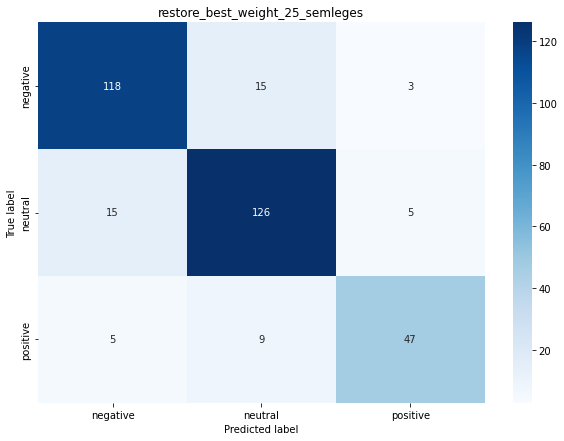

In [18]:
import winsound

for i in range(1,10):
  try: 
    ITER = str(i)
    print("Iteration ", ITER)
    history, result, predict = fit_model()
    evaluate(predict, result, y_test_labels)
  except Exception as e:
    for i in range(1, 5):
      winsound.Beep(100 + i * 100, 400)


for i in range(5, 12):
  winsound.Beep(100 + i * 100, 400)